# INF8801 - LAB 5

# Seam carving

We will be looking at seam carving for shrinking or enlarging images. In seam carving, the idea is to iteratively remove or add minimal energy seams.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
import scipy, scipy.ndimage, scipy.signal

(-0.5, 377.5, 255.5, -0.5)

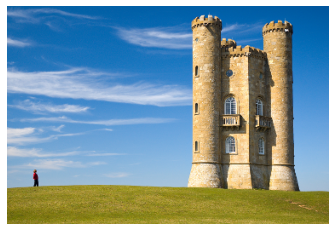

In [12]:
image = cv2.imread("./data/src.png") #replace by image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image/255
plt.imshow(image)
plt.axis("off")

# 1. Image Energy

In [13]:
def getEnergy(image):
    """
    Computes the energy of the gradient of an image
    :param image: np.array, RGB image with size (h, w, c).
    :return: energy: np.array, size (h, w).
    """
    h, w, c = image.shape
    kernelGradientX = [[-1,0,1],[-2,0,2],[-1,0,1]] #Gradient avec filtre Sobel
    kernelGradientY = [[-1,-2,-1],[0,0,0],[1,2,1]]
    energy = np.zeros((h,w))
    for i in range(c):
        gradientX = scipy.signal.fftconvolve(image[:,:,i], kernelGradientX, "same") #calcul des gradients par convolution avec des noyaux
        gradientY = scipy.signal.fftconvolve(image[:,:,i], kernelGradientY, "same")
        energy = energy + abs(gradientX) + abs(gradientY) #On peut changer le calcul d'energie (norme L2 par exemple) mais nous n'avons pas vu de différences notables.
    
    return energy

### Visualising results

Text(0.5, 1.0, 'Energy of our image')

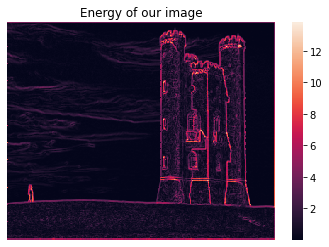

In [14]:
e = getEnergy(image)
sns.heatmap(e)
plt.axis("off")
plt.title("Energy of our image")

# 2. Image Costs

In [15]:
def pathCost(energy):
    """
    Computes the cumulative energy of the map starting at the top of the image. For each pixel with position (i,j), when we look at the row above, we add the minimal energy of it's immediate neighbours, i.e. the minimal energy between (i-1, j-1), (i-1, j) and (i-1, j+1.

    :param energy: np.array, size (h,w), output of getEnergy()
    :return: costs: np.array, same size as energy.
    """
    costs = np.zeros_like(energy)
    
    costs = energy.copy()

    #On regarde a chaque fois les 3 pixels d'au dessus (ou les deux si on est sur un bord) pour trouver le pixel avec le moins d'énergie. On fait cela a partir d'un pixel en haut de l'image
    #En additionnant les energies minimales cumulées trouvées, cela nous donne un cout total minimal pour arriver a un pixel donné.
    for i in range(1,len(costs)):
        for j in range(len(costs[0])):
            if j==0:
                costs[i,j] += min(costs[i-1,j], costs[i-1,j+1])
            elif j==len(costs[0])-1:
                costs[i,j] += min(costs[i-1,j], costs[i-1,j-1])
            else:
                costs[i,j] += min(costs[i-1,j], costs[i-1,j-1], costs[i-1,j+1])
        

    return costs

### Visualising results

Text(0.5, 1.0, 'Cumulative costs')

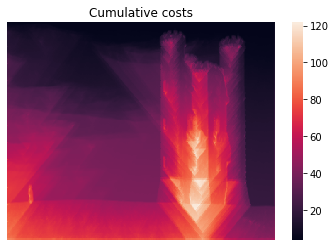

In [16]:
c = pathCost(e)
sns.heatmap(c)
plt.axis("off")
plt.title("Cumulative costs")

# 3. Minimal Energy seam

In [17]:
def getSeam(costs):
    """
    Computes the seam of minimal energy in an image
    :param costs: np.array, size (h,w). Output of pathCost() function.
    :return: seam: np.array, size (h,). For each row, contains the index of where the seam goes through.
    """
    h, w = costs.shape
    seam = np.ones(h).astype("int64")
    j = np.argmin(costs[-1])
    seam[-1] = j
    
    #On parcourt la map de coût à l'envers 
    #On cherche le chemin le moins couteux en remontant
    for i in range(len(costs)-2, -1, -1):
            if j==0:
                seam[i] = np.argmin(costs[i,j:j+2]) + j
            elif j==len(costs[0])-1:
                seam[i] = np.argmin(costs[i,j-1:j+1]) + j - 1
            else:
                seam[i] = np.argmin(costs[i,j-1:j+2]) + j - 1
            j=seam[i]
        
    
    return seam

### Visualising results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Minimal Energy seam')

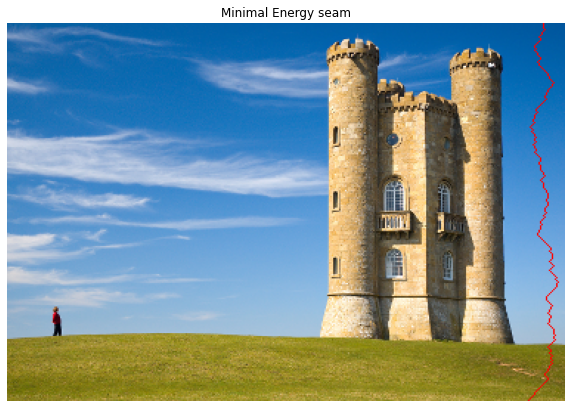

In [18]:
s = getSeam(c)
tmp = image.copy()
h, w, _ = image.shape
for i in range(h):
    tmp[i, s[i]] = (255,0,0) #On met le seam en rouge pour le voir
plt.figure(figsize=(10, 10))
plt.imshow(tmp)
plt.axis("off")
plt.title("Minimal Energy seam")

# 4. Shrinking an image by 25%

In [19]:
def shrinkH(img, newWidth):
    """
    Image must have shape (h, w, c). If image is grayscale, c=1.. Shrinks a given image to a new width equal to newWidth.
    :param
            img: np.array, image we want to shrink
            newWidth: int, must verify 1 <  newWidth < img.shape[1]

    :return:
            res: np.array, size (h, newWidth, c). Shrinked image
    """

    h, w, c = img.shape
    nSeams = w - newWidth
    print(" We are going to compute {} seams".format(nSeams))
    res = img.copy()
    energyMap = getEnergy(res)
    for i in tqdm(range(nSeams)):
        seam = getSeam(pathCost(energyMap))
        
        resTemp = np.zeros((h, len(res[0])-1, 3))
        energyMapTemp = np.zeros((h, len(res[0])-1))
        
        #Retirer le seam à l'energy map et à l'image
        for j in range(h):
                energyMapTemp[j] = np.concatenate((energyMap[j,0:seam[j]],energyMap[j, seam[j]+1:]))
                resTemp[j] = np.concatenate((res[j,0:seam[j]],res[j, seam[j]+1:]))
                
        res = resTemp.copy()
        energyMap = energyMapTemp.copy()
        
    return res

### Visualising results

  0%|          | 0/95 [00:00<?, ?it/s]

 We are going to compute 95 seams


100%|██████████| 95/95 [00:11<00:00,  7.95it/s]


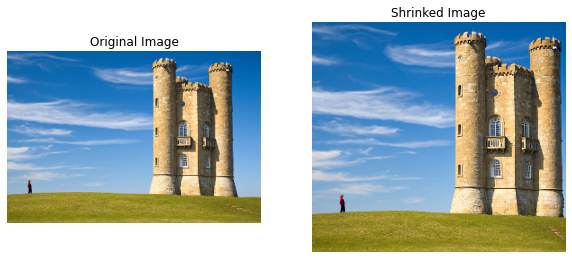

In [20]:
shrinked = shrinkH(image, int(image.shape[1] * 0.75)) #Change the scaling here, by specifying the new widht. Must be smaller than the original width

f, axs = plt.subplots(1,2, figsize=(10,8))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].title.set_text("Original Image")
axs[1].imshow(shrinked)
axs[1].axis("off")
axs[1].title.set_text("Shrinked Image")

# 5. Enlarging an image by 25%

In [21]:
def enlargeH(img, newWidth):
    """
    Image must have shape (h, w, c). If image is grayscale, c=1.. Enlarges a given image to a new width equal to newWidth.
    :param
            img: np.array, image we want to shrink
            newWidth: int, must verify img.shape[1] < newWidth

    :return:
            res: np.array, size (h, newWidth, c). Enlarged image
    """
    h, w, c = img.shape
    nSeams =  newWidth -w
    print(" We are going to compute {} seams".format(nSeams))
    res = img.copy()
    energyMap = getEnergy(res)
    seams=[]
    
    #Calcul des seams sur la même energy map. On trouve les nSeams les moins energetiques, comme si on voulait les enlever, sans vraiment les enlever sur l'image (seulement sur l'energy map)
    for i in tqdm(range(nSeams)):
        seam=getSeam(pathCost(energyMap))
        seams.append(seam)
        energyMapTemp = np.zeros((h, len(energyMap[0])-1))
        
        for j in range(h):
                energyMapTemp[j] = np.concatenate((energyMap[j,0:seam[j]],energyMap[j, seam[j]+1:]))
                
        energyMap = energyMapTemp.copy()
    
    #FInalement, on ajoute les seams de droite à gauche à l'image que nous venons de calculer : on ajoute alors des seams peu energetiques qui ne vont pas changer le contenu important. 
    #On ajoute un seam dans l'image en moyennant ses pixels avec ses voisins de droite et gauche
    seams.sort(key=lambda x: x[0],reverse=True)
    for i in range(len(seams)):
        seam=seams[i]
        restemp = np.zeros((h, len(res[0])+1, 3))
        for j in range(h):
            restemp[j]=np.concatenate((res[j,0:seam[j]+1],[(res[j,seam[j]]+res[j,seam[j]+1])/2],res[j, seam[j]+1:]))
        res=restemp.copy()
    return res

### Visualising results

  1%|          | 1/94 [00:00<00:13,  6.95it/s]

 We are going to compute 94 seams


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


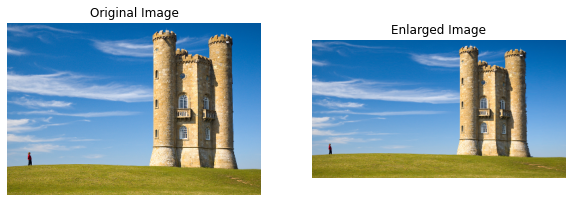

In [22]:
enlarged = enlargeH(image, int(image.shape[1] * 1.25)) #Change the scaling ratio here, by specifying the new width. Must be larger than original width
f, axs = plt.subplots(1,2, figsize=(10,8))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].title.set_text("Original Image")
axs[1].imshow(enlarged)
axs[1].axis("off")
axs[1].title.set_text("Enlarged Image")

